In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print u'Так надо'

# Машинное обучение и майнинг данных

## 02/03/2017 SVM, Kernel Trick, Бустинг

## В предыдущий раз..

Мы разговаривали про линейные модели

* Рассмотрели линейную регрессию
* Рассмотрели логистическую регрессию
* Метод градиентного спуска для поиска коэффициентов моделей
* Изучили регуляризацию в линейных моделях

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg/512px-Svm_separating_hyperplanes_%28SVG%29.svg.png' width=400></center>

# Про геометрию линейных моделей

Уравнение прямой задаётся как: $$g(x) = w_0 + w_1x_1 + w_2x_2 = w_0 + \langle w, x \rangle = w_0 +  w^\top x $$

* Если $g(x^*) > 0$, то $y^* = \text{'черный'} = +1$
* Если $g(x^*) < 0$, то $y^* = \text{'белый'} = -1$
* Если $g(x^*) = 0$, то мы находимся на линии
* т.е. решающее правило: $y^* = sign(g(x^*))$

Некоторые геометрические особенности
* $\frac{|g(x)|}{||w||}$ - расстояние от точки $x$ до гиперплоскости, степень "уверенности" в классификациий
* Величину $M = y(\langle w, x \rangle + w_0) = y \cdot g(x)$ называют **отступом**(margin)

Если для какого-то объекта $M \geq 0$, то его классификация выполнена успешно.

$$L(w) = \sum_i [y^{(i)} (\langle w, x^{(i)} \rangle + w_0) < 0] \rightarrow \min_{w, w_0}$$
<center><img src='http://jaquesgrobler.github.io/Online-Scikit-Learn-stat-tut/_images/plot_sgd_loss_functions_11.png' width=600></center>

###  Линейноразделимый случай с двумя классами
* Заметим что $g(x) = w_0 + \langle w, x \rangle$ и $g'(x) = c \cdot (w_0 + \langle w, x \rangle)$ задают одну и ту же гиперплоскость
* Подберем $c$ таким образом, чтобы $\min\limits_i M_i = \min\limits_i y \cdot g(x_i) = 1$
<center><img src='./img/margin.png'></center>
* Таким образом выполняются следующие неравенства:
    * $w_0 + \langle w, x_i \rangle \geq 1$, если $y_i = + 1$
    * $w_0 + \langle w, x_i \rangle \leq - 1$, если $y_i = - 1$

* Разделяющая полоса:  $ -1 \leq w_0 + \langle w, x \rangle \leq +1$
* Ширина разделяющей полосы:
 $$\langle (x_{+} -  x_{-}) , \frac{w}{||w||}\rangle = \frac{\langle w, x_{+} \rangle - \langle w, x_{-} \rangle }{||w||} = \frac{2}{||w||}  \rightarrow \max$$
 
 
* Таким образом мы придем к оптимизационной задаче:
$$
\begin{cases} 
   \frac{1}{2} ||w||^2  \rightarrow \min  \\
   y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 \quad i=1\dots n
\end{cases}
$$


* Имеет единственное решение при линейной разделимости

По теореме Куна-Таккера:


\begin{cases} 
   \mathcal{L}(w,w_0,\lambda) = \frac{1}{2} ||w||^2  - \sum\limits_i \lambda_i \left( y^{(i)}(\langle w, x \rangle + w_0 )  - 1\right)  \rightarrow \min\limits_{w,w_0}\max\limits_{\lambda}  \\
   \lambda_i \geq 0 \quad i=1\dots n\\
   \lambda_i = 0 \text{, либо }  \langle w, x^{(i)} \rangle + w_0 = y^{(i)} \quad i=1\dots n
\end{cases}
Объекты, для которых  $\lambda_i \neq 0$ называются ** опорными ** 


Необходимое условие:
*  $\frac{\partial \mathcal{L} }{\partial w} = w - \sum\limits_i \lambda_iy_ix_i = 0 \quad \Rightarrow  \quad w = \sum\limits_i \lambda_iy_ix_i$
*  $\frac{\partial \mathcal{L} }{\partial w_0} = \sum\limits_i \lambda_iy_i = 0$

Если подставить  эти результаты в $\mathcal{L}$ то получится
\begin{cases}
\mathcal{L}(\lambda) = \sum\limits_i\lambda_i  - \frac{1}{2} \sum\limits_i\sum\limits_j \lambda_i \lambda_j  y_i y_j (\langle x_i, x_j \rangle)  \rightarrow \max\limits_\lambda  \\
\lambda_i \geq 0 \quad i=1\dots n \\
\sum\limits_i \lambda_iy_i = 0
\end{cases}

**Зависит не от самих объектов, а от их скалярноо произведения! **

In [2]:
from sklearn.datasets.samples_generator import make_classification

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def plot_svc_log_decision_function(clf1, clf2, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    P2 = clf2.decision_function(XY)
    P2 = P2.reshape(XX.shape)
    # plot the margins
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)
    
    ax.contour(XX, YY, P2, colors='r', label='logreg',
               levels=[0], alpha=0.5,
               linestyles=['-'])

    
def plot_svc_decision_function(clf1, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    # plot the margins
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)
    

def lin_sep_svm_demo(class_sep=2):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                n_redundant=0, n_clusters_per_class=1, random_state=31)
    # x_line = np.linspace(np.min(X) - 0.5, np.max(X) + 0.5)

    lin_svm = SVC(kernel='linear', C=100).fit(X, y)
    
    log_reg = LogisticRegression(C=100).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_log_decision_function(lin_svm, log_reg)
    plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

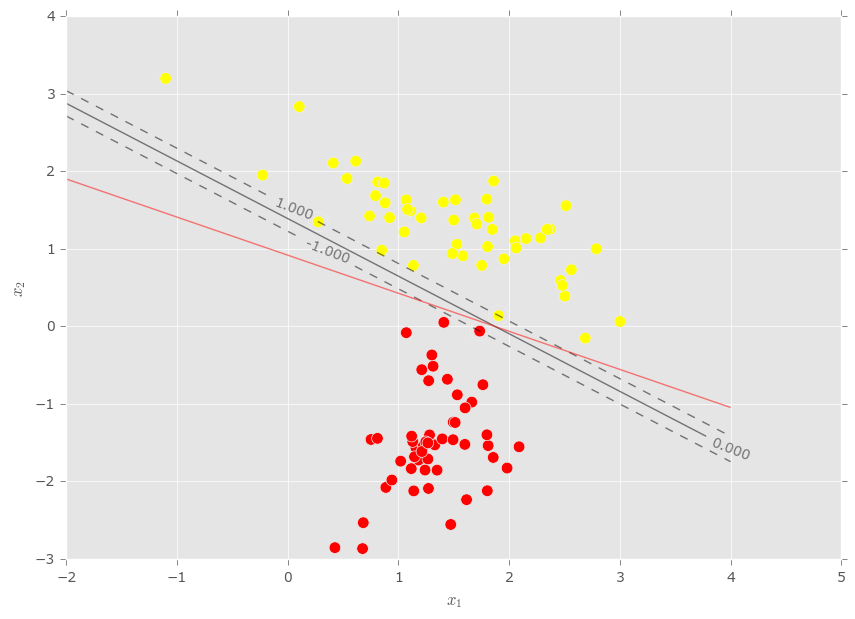

In [3]:
interact(lin_sep_svm_demo, class_sep=FloatSlider(min=0.4, max=4, step=0.1, value=2))

### Неразделимый случай 

Будем допускать пропуск объектов за разделительную линию
* Вместо условия $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1$
* Будет условие $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 - \xi_i, \quad \xi_i \geq 0$

<center><img src='./img/slack.png'></center>

А целевой функционал заменим на 

$$ \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi}  $$

Заметим, что изначальный целевой функционал
$$ \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi}  $$
Можно представить в виде
$$ \frac{1}{2С} ||w||^2 + \sum\limits_i(1-M_i)_+ \rightarrow \min\limits_{w,w_0}, $$
где $M_i$ - это отступ объекта  $x^{(i)}$

In [4]:
def lin_sep_svm_demo_C(class_sep=2, C=10):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                n_redundant=0, n_clusters_per_class=1, random_state=31)
    # x_line = np.linspace(np.min(X) - 0.5, np.max(X) + 0.5)

    lin_svm = SVC(kernel='linear', C=C).fit(X, y)
    
    log_reg = LogisticRegression(C=C).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_log_decision_function(lin_svm, log_reg)
    plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

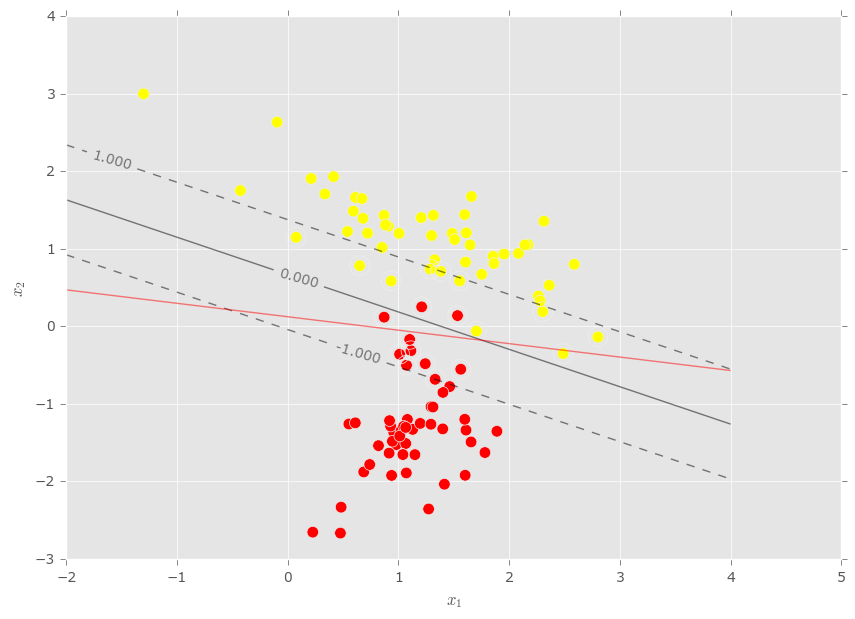

In [5]:
interact(lin_sep_svm_demo_C, class_sep=FloatSlider(min=0.2, max=4, value=2, step=0.2), C=FloatSlider(min=0.002, max=10, step=0.002, value=1))

# Ядра и спрямляющие пространства

In [6]:
from sklearn.datasets.samples_generator import make_circles
from mpl_toolkits import mplot3d

def demo_nonlin_data():
    X, y = make_circles(n_samples=100, factor=0.1, 
                        noise=0.1, random_state=0)

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)

    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    r = X[:, 0] ** 2 + X[:, 1] ** 2
    
    ax = fig.add_subplot(1, 2, 2)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap='autumn')
    ax.view_init(elev=30, azim=30)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_1^2 + x_2^2$')

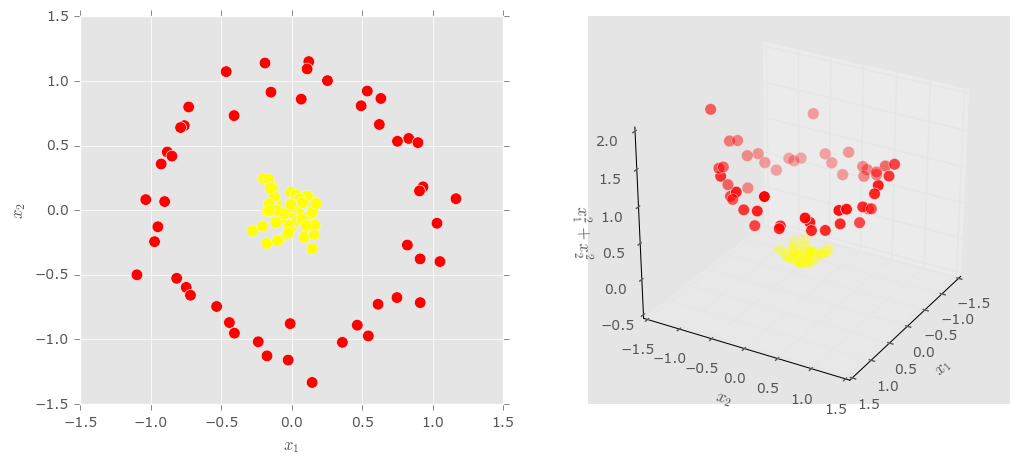

In [7]:
demo_nonlin_data() 

* $\psi: X \rightarrow H$
* $H$ - пространство большей размерности, в котором классы становятся линейноразделимыми называется **спрямляющим**.
* Разделяющся гиперплоскость в таком пространстве будет линейной, но при проекции на исходное пространство $X$ - нет

* Представим, что мы строим SVM в $H$
\begin{cases}
\mathcal{L}(\lambda) = \sum\limits_i\lambda_i  - \frac{1}{2} \sum\limits_i\sum\limits_j \lambda_i \lambda_j  y_i y_j (\langle \psi(x_i), \psi(x_j) \rangle)  \rightarrow \max\limits_\lambda  \\
0 \leq \lambda_i \leq C \quad i=1\dots n \\
\sum\limits_i \lambda_iy_i = 0
\end{cases}
* Получается, нам не нужно в явном виде выражать преобразование $\psi$, нужно лишь знать результат скалярного произведения!
* Kernel tric!
* $k(x_i, x_j) = \langle \psi(x_i), \psi(x_j) \rangle$ - ядро

** Теорема Мерсера **<br/>
Функция $k(u, v)$ является ядром тогда и только тогда, когда она симметрична $k(u, v) = k(v, u)$, и неотрицательно определена, $ \int_X \int_X k(u,v) f(u)f(v) du dv \geq 0$,  $\forall f: X \rightarrow \mathbb{R}$

** Некоторые способы построения ядер **
1. Скалярное произведение - ядро, $k(u,v) = \langle u, v \rangle$
2. Константа - ядро, $k(u,v) = 1$
3. $\forall \phi: X \rightarrow \mathbb{R}$ произведение $k(u,v) =  \phi(u) \phi(v)$ - ядро
4. $k(u,v)  = \alpha_1k_1(u,v)  + \alpha_2k_2(u,v) $ - ядро
4. $k(u,v)  =  k_1(u,v) \cdot k_2(u,v) $ - ядро
5. $\forall \phi: X \rightarrow X \quad k(u,v) = k'(\phi(u),\phi(v)) $ - ядро

\begin{equation}
\begin{split}
k(u,v) & =  \langle u, v \rangle^2  = \\  & = \left(\sum_iu_i v_i\right) \left(\sum_ju_j v_j\right) = \\ & = \sum_{i,j} u_iu_jv_iv_j = \\ & =  \sum_{i,j} (u_iu_j)(v_iv_j )
\end{split}
\end{equation}

$$\psi(u) = ?$$

\begin{equation}
\begin{split}
k(u,v) & =  (\langle u, v \rangle + c)^2  = \\ &  = \sum_{i,j} (u_iu_j)(v_iv_j ) + \sum_i(\sqrt{2c}u_i)(\sqrt{2c}v_i) + c^2
\end{split}
\end{equation}

$$\psi(u) = ?$$

В scikitlearn есть следующие ядра:

1. линейное (linear): $\langle u, v\rangle.$
2. полиномиальное (polynomial): $(\gamma \langle u, v\rangle + с)^d$, $d$ указывается через `degree`, $с$ через `coef0`.
3. Radial basis function kernel (rbf): $e^{(-\gamma  \cdot |u - v|^2)}$, $\gamma$ указывается через `gamma> 0`.
4. sigmoid: $\tanh(\gamma \langle u,v \rangle + r)$ $r$ указывается через `coef0`.

In [8]:
def lin_sep_svm_demo_kernel_C(class_sep=2, kernel='linear', C = 1, gamma=1.2, degree=2, coef0=0.0):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                n_redundant=0, n_clusters_per_class=1, random_state=31)
    # x_line = np.linspace(np.min(X) - 0.5, np.max(X) + 0.5)

    lin_svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=0.0).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_decision_function(lin_svm)
    plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

In [9]:
from IPython.display import YouTubeVideo

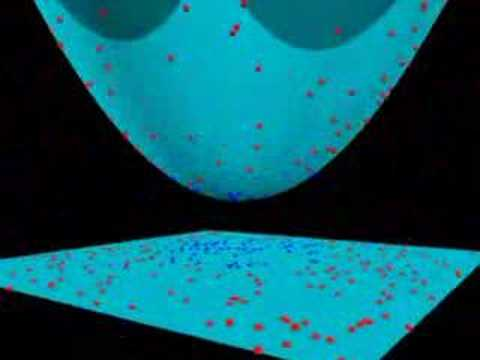

In [10]:
YouTubeVideo('3liCbRZPrZA', width=640, height=480)

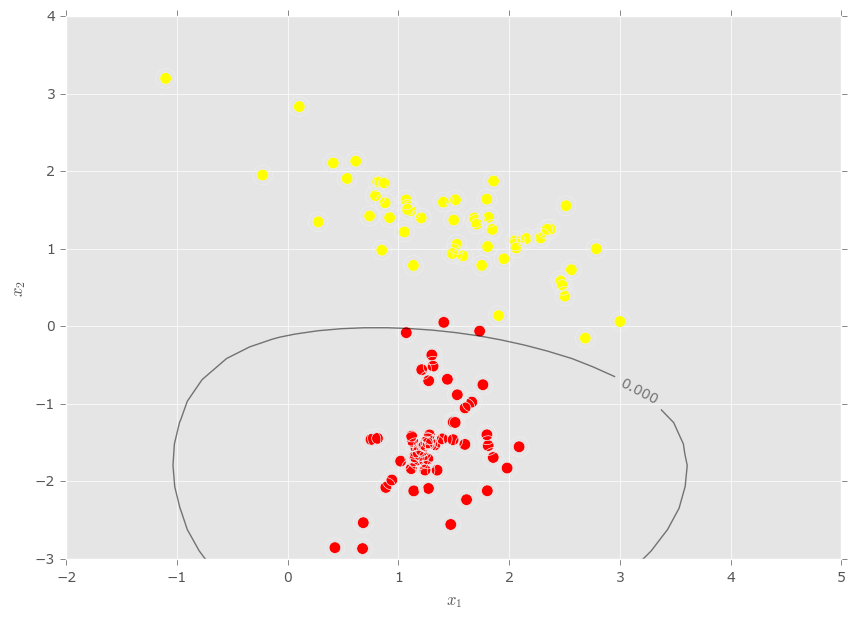

In [11]:
interact(lin_sep_svm_demo_kernel_C, class_sep=FloatSlider(min=0.2, max=4, value=2, step=0.2), kernel=['rbf', 'linear', 'poly'],         coef0=FloatSlider(min=0, max=10, step=0.2, value=0),         C=FloatSlider(min=0.002, max=10, step=0.002, value=1),         degree=FloatSlider(min=2, max=3, step=1, value=2),         gamma=FloatSlider(min=0.01, max=5, step=0.01, value=0.5),)

# Бустинг

## Bias  vs Variance

* Рассмотрим задачу регрессии и ошибку MSE. <br\>
* Пусть $y$ - целевая переменная, а $x$ - предикторы. Мы предполагаем, что имеет место зависимость $ y = f(x) + \epsilon $ где $ \epsilon $ случайная ошибка со средним 0 и дисперсией $\epsilon \sim \mathcal{N}(0,\sigma_\epsilon^2) $.

* Оцениваем модель $ a(x) = \hat{y} $.

## Bias vs Variance

Тогда матожидание ошибки модели в точке $ x $ это:

\begin{equation}
\begin{split}
\text{Error}(x) & = E\left[(a(x) - y)^2\right] = E\left[a(x)^2 - 2a(x)y + y^2\right]  = \\ & = E\left[(a(x) - E[a(x)])^2\right] + E[a(x)]^2 - 2E[a(x)]y + E\left[(y - E[y])^2\right] + E[y]^2 = \\ & = E\left[(a(x) - E[a(x)])^2\right]  + \left(a(x) - f(x)\right)^2 +  E\left[(y - f(x))^2\right] = \\ & = \text{Variance} + \text{Bias}^2  + \text{Noise}
\end{split} 
\end{equation}


\begin{equation}
\begin{split}
Error & = E\left[(a(x) - E[a(x)])^2\right]  + \left(a(x) - f(x)\right)^2 +  E\left[(y - f(x))^2\right] = \\ & = \text{Variance} + \text{Bias}^2  + \text{Noise}
\end{split}
\end{equation}

Эти компоненты можно проинтерпретировать так:
* $\text{Variance}$ (Разброс) - чувствительность модели к данным. Высокие разброс чаще всего означает, что модель переобучена (overfitting)
* $\text{Bias}$ (Смещение) - точность модели, насколько идеален алгоритм. Высокое смещение чаще всего означает, что модель недообучена (underfitting).
* $\text{Noise}$ (Шум) - это просто шум.


Для иллюстрации рассмотрим следующую картинку
<center><img src='https://i.stack.imgur.com/r7QFy.png' width='650'></center>

На эти компоненты можно влиять несколькими способами, например, подбирая гиперпараметры моделей или влиять на их сложность. В итоге, надо найти некий баланс. <br/>

<center><img src='http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png' width=800></center>

Ансамблевые методы воздействуют на Bias - Variance [[1](http://www.hlt.utdallas.edu/~vgogate/ml/2015s/lectures/EnsembleMethods.pdf)]

* Бэггинг и случайный лес подход должен уменьшать Variance составляющую ошибки.
* Бустинг что бустинг снижет **Bias** и **Variance**

##  Бустинг

<center><img src='https://s9.postimg.org/lq3lethhr/boosting.png' width='850'></center>

## AdaBoost

Введем следующие обозначения:
* $t_k$ - базовый классификатор, полученный на шаге $k$, возвращает  $\{-1, 1\}$ для каждого объекта
* $\alpha_k$ - вес базового классификатора, полученного на шаге $k$
* $w_k(i)$ - веса объектов на шаге $k$
* $x_i$ - $i$-й объект, $i = 1, \dots, N$
* $y_i=\{-1, 1\}$ - метки класса для $i$-го объекта 



Конечное предсказание получается из взвешенной комбинации предсказания базовых моделей:
$$ T(x^*) = sign(\sum\limits^{K}_{k=1}\alpha_kt_k(x^*)) $$

Наша цель - минимизировать количество ошибок на всей выборке ..

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] $$

.. которые мы мажорируем экспонентой =)

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] \leq \frac{1}{N}\sum\limits_{i=1}^N e^{(-y_i\sum_k\alpha_kt_k(x_i))} $$

Если мы посчитаем ошибки $E_1, E_2, E_3,...$ на каждом шаге, то это даст нам правило для обновления весов объектов. <br\>
А если мы посчитаем производную ошибки $E_t$ по $\alpha_t$, то это даст нам правило для обновления весов базовых моделей. <br\>

Алгоритм обучения **Discrete AdaBoost**:

* Инициализируем веса объектов $w_1(i) = \frac{1}{N}$ 
* Для $k = 1..K$
    * Обучить классификатор $t_k(x) \in \{-1, 1\}$ используя веса объектов $w(i)_k$
    * Вычислить взвешенную ошибку $\epsilon = \frac{\sum_i w_{k}(i)[y_i \neq t_k(x_i) ]}{\sum_i w_{k}(i)}$
    * Вычислить вес базовой модели $\alpha_k = \ln\frac{1-\epsilon}{\epsilon}$
    * Пересчитать веса объектов $w_{k+1}(i) = \frac{w_{k}(i) e^{-\alpha_k y_i t_k(x_i)}}{W}$, $i = 1, \dots, N$,где $W = \sum_i w_k(i) e^{-\alpha_k y_i t_k(x_i)}$ - нормировочная константа.
* $T(x) = sign(\sum_k \alpha_k t_k(x))$

*Обратите внимание* что базовые модели как правило явлюятся слабыми (weak learners), т.е. их качество должно едва ли превышать бросание монетки. На рисунке выше - это логические правила на одном из признаков, что равносильно дереву решений с глубиной 1.

In [12]:
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


def ada_demo(n_est=1):

    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,), n_estimators=n_est, learning_rate=0.1)
    ada.fit(X, y)
    

    plt.figure(figsize=(7,5))

    xx1, xx2 = np.meshgrid(np.arange(-1.5, 2.5, 0.1),
                           np.arange(-1, 1.5, 0.1))

    y_hat = ada.predict(np.c_[xx1.ravel(), xx2.ravel()])
    
    y_hat = y_hat.reshape(xx1.shape)

    plt.title('iteration = %d' % n_est )
    plt.contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y)

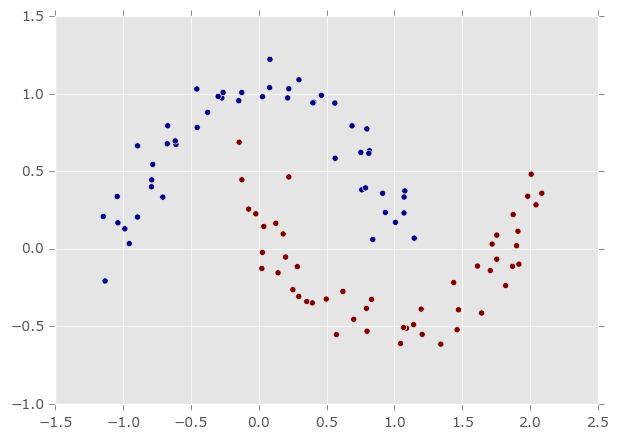

In [13]:
X, y = make_moons(noise=0.1)
plt.figure(figsize=(7,5))
plt.scatter(X[:, 0], X[:, 1], c=y)

<function __main__.ada_demo>

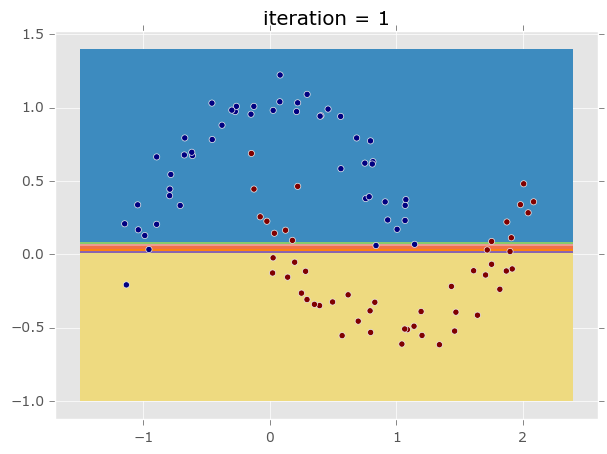

In [14]:
interact(ada_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

## Градиентный бустинг

По своей структуре метод похож на алгоритм градиентного спуска - отсюда и такое название.

Пусть дана дифференцируемая функция потерь $L(T_k(x), y)$ (для любой задачи - регрессии или классификации) <br\>
Функционал качества - $Q(T, y) = \sum_iL(T_k(x_i), y_i) = \sum_iL(T_{k-1}(x_i) + \alpha t_{k}(x_i), y_i)$

На секунду представим, что $t_{k}(x)$ - это просто вектор значений. Тогда задачу оптимизации $Q(T, y)$ можно решать простым градиентным методом:

* $T_0$ - начальное приближение
* $T_k = T_{k-1} - \alpha g$ - делаем градиентный шаг
* где $g_i = \frac{\partial L(T_{k-1}(x_i), y_i)}{\partial t_{k-1}(x_i)}$, $i = 1, \dots, N$ - градиент функции потерь

Тогда $t_{k}(x) =  \arg\min\limits_{t} \sum\limits_i(t_{k}(x_i) - g_i)^2$, $\alpha$ определяется в одномерное задаче оптимизации $ \sum_iL(T_{k-1}(x_i) + \alpha t_{k}(x_i), y_i) \rightarrow \min\limits_\alpha$
 


Наибольший успех, а потому и популярность, получил градиентный бустинг на деревьях решений.

С этой его реализацией в sklearn мы сейчас поработаем.

На досуге обратите внимание на модель `xgboost`. Вводный курс по этой модели можно найти [тут](http://education.parrotprediction.teachable.com/p/practical-xgboost-in-python)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

def grad_demo(n_est=1):

    X = np.random.uniform(1, 100, 500)

    y = np.log(X) + np.random.normal(0, .3, 500)
    plt.scatter(X, y)
    

    gbr = GradientBoostingRegressor(n_estimators=n_est, learning_rate=0.15)
    gbr_full = GradientBoostingRegressor(n_estimators=200, learning_rate=0.15)
    gbr.fit(X.reshape(-1,1), y)
    gbr_full.fit(X.reshape(-1,1), y)
    
    x_range = np.linspace(X.min(), X.max(), 100).reshape((-1,1))

    for y_hat in gbr.staged_predict(x_range):
        plt.plot(x_range, y_hat, alpha=0.4, c='g')

    y_hat = gbr_full.predict(x_range)
    
    plt.title('Estimators %d' % n_est)
    plt.plot(x_range, y_hat, c='r')

<function __main__.grad_demo>

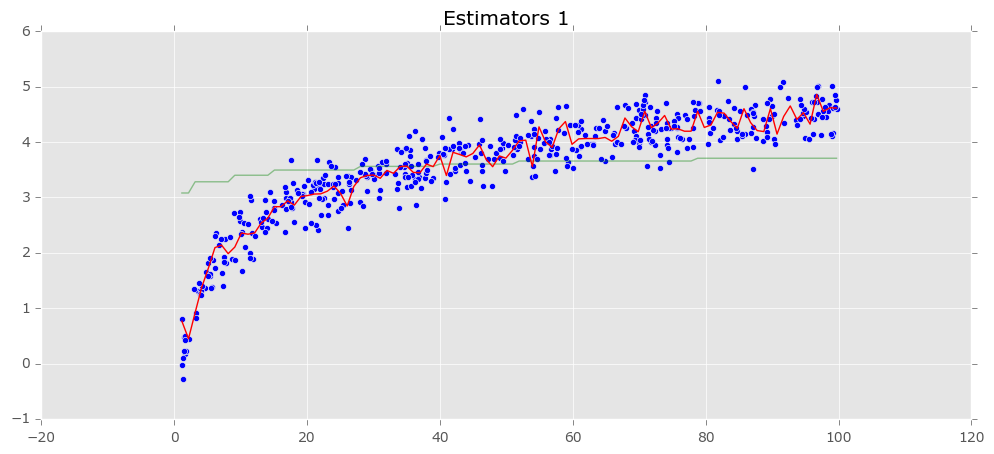

In [16]:
interact(grad_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))